# CCOB NB Run6 analysis of circles

J. Bregeon - August 2023

### Setup Rubin LSST software stack

In [1]:
! eups list -s lsst_distrib

   gdf42428520+d521942ec3 	current w_2023_21 setup


In [2]:
!setup -j -r ./eo_pipe

In [3]:
import eo_pipe

## Import necesary libraries

In [4]:
%matplotlib inline
import pylab as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr.isrTask import IsrTask
from lsst.cp.pipe.cpCombine import CalibCombineTask

## Geometry


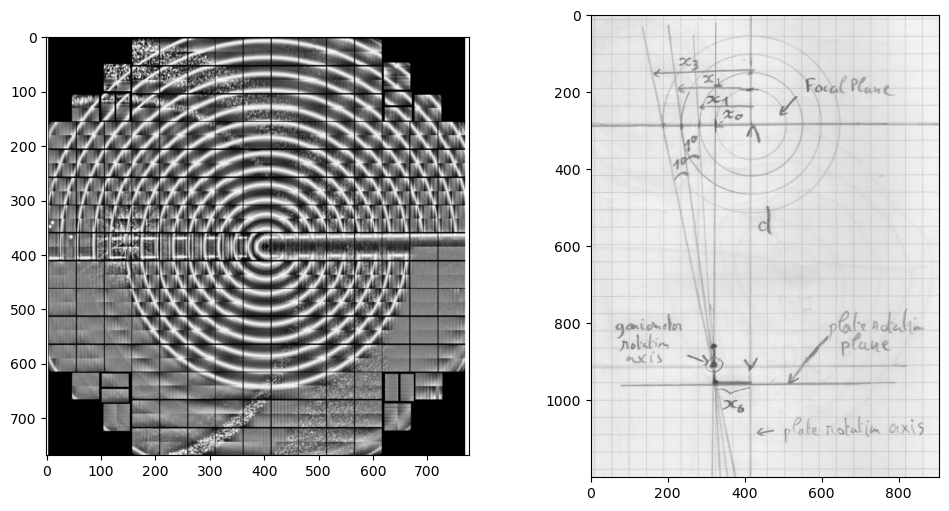

In [5]:
import matplotlib.image as mpimg
plt.rcParams["figure.figsize"] = [12, 6]
fig_, axd = plt.subplots(1, 2)
img = mpimg.imread('../data/circles_MC_C_20230619_000087_image.png')
imgimg = axd[0].imshow(img)
imgdraw = mpimg.imread('../data/circles_MC_C_20230619_000087_drawing.png')
drawplot = axd[1].imshow(imgdraw)
plt.show()

When drawing circles with the narrow beam, the full system of equations is the following:
\begin{equation}
    \begin{cases}
      d & \text{distance from the goniometer rotation axis to the focal plane}\\
      x_0 & \text{radius of the inner circle} \\
      d_x = x_2 - x_1 & \text{measured distance between 2 circles} \\
      \theta_2 - \theta_1 = 1^\circ & \text{within the goniometer precision} \\
      tan(\theta_1) = \frac{x_1-x_0}{d} &  x_1 \text{ radius of the 1st circle}\\
      tan(\theta_2) = \frac{x_2-x_0}{d} &  x_2 \text{ radius of the 2nd circle}\\
    \end{cases}       
\end{equation}

That system can be reduced to:<br>
\begin{equation}
d=\frac{d_x}{tan(\theta_2)-tan(\theta_1)}
\end{equation}

And the measurement done again with each pair of circles, but the inner ring.

Uncertainties:
- the goniometer resolution to rotate by $1^\circ$ should be pretty good, I could check the specs.
- the absolute value of the goniometer rotation angle is not well known, it is believed that $b=1^\circ$ is normal incidence.
- the fit of the position of the ring should be good as well, although with the current code only the distance between 2 rings within the same ccd can be measured.
- more that I have forgotten...

## Define helper function to display image nicely

In [6]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [7]:
def getObId(butler, obs_id="MC_C_20230619_000087", detector=None):
    if detector is not None:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'",
                                                  detector=detector)))
        print(f'Found {len(refs)} CCD exposure.')
        print(butler.get(refs[0]).info.getDetector().getName())

    else:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'")))
        print(f'Found {len(refs)} CCD exposures.')
        print(butler.get(refs[0]).info.getVisitInfo())
    return refs

def getccdsmap(refs):
    ccdmap = {}
    for i, one in enumerate(refs):
        ccdmap[butler.get(one).info.getDetector().getName()] = i
    return ccdmap


def plot_ccd(ccd_name='R22_S11'):
    myccd = refs357[ccdmap[ccd_name]]
    bias = butler.get(myccd)
    
    isr = IsrTask()
    isr.config.doLinearize=False
    isr.config.doDark=False
    isr.config.doBias=False
    isr.config.doFlat=False
    isr.config.doDefect=False
    isr.config.overscan.fitType: 'MEDIAN_PER_ROW'
    postISRCCD = isr.run(bias)
    display(postISRCCD.exposure,bias.getMetadata()["FILENAME"])
    plt.show()
    return postISRCCD


In [8]:
# more functions to fit the beam slices
from scipy import optimize
import numpy as np

def show_hv_slices(imgarray, vpix, hpix, ccdname):
    plt.rcParams["figure.figsize"] = [12, 6]
    fig, ax = plt.subplots(1, 2)
    subax = imgarray[vpix]
    x = range(len(subax))
    ax[0].plot(x, subax)
    ax[0].set_title(f'Horizontal slice on {ccdname} at pixel {vpix}')
    subay = np.transpose(imgarray)[hpix]
    y = range(len(subay))
    ax[1].plot(y, subay)
    ax[1].set_title(f'Vertical slice on {ccdname} at pixel {hpix}')

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-1/2*((x-mean)/stddev)**2)

def fitgauss(ax, imgarray, axis, pixsec, amin, amax, ccdname):
    plt.rcParams["figure.figsize"] = [9, 6]
    if axis=='x':
        suba1 = imgarray[pixsec][amin:amax]
    else:
        suba1 = np.transpose(imgarray)[pixsec][amin:amax]
    x = range(len(suba1))
    ax.plot(x, suba1)

    popt, _ = optimize.curve_fit(gaussian, range(len(suba1)), suba1)
    ax.plot(x, suba1)
    ax.plot(x, gaussian(x, *popt))
    ax.set_title(f'Fitting slice of {ccdname}')

    # print(*popt)
    peak_value = popt[1]+amin
    print(f'peak mean/sigma = {peak_value:.1f}/{popt[2]:.1f}')
    return peak_value


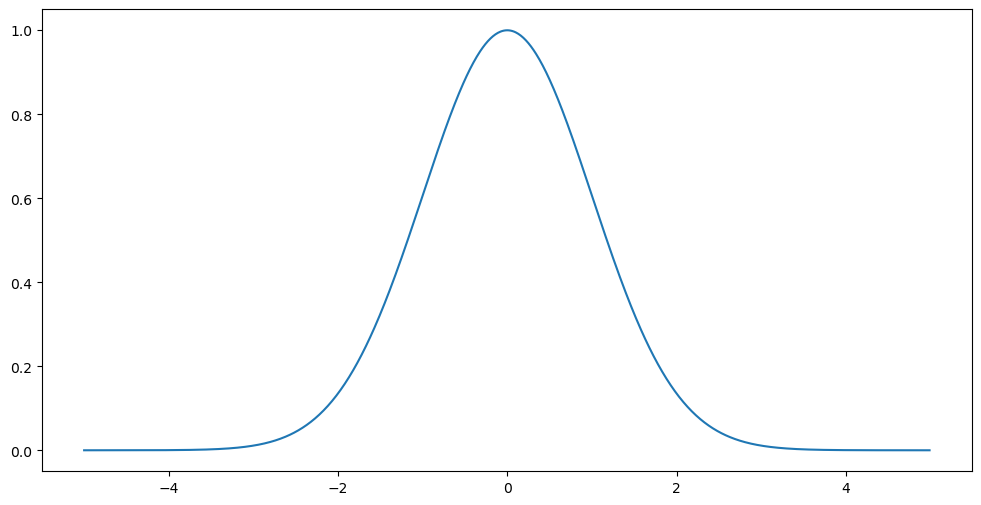

In [9]:
# Check the gaussian formula...
x10=np.arange(-50, 50, 0.1)
xx=x10/10.
y = []
[y.append(gaussian(x, 1, 0, 1)) for x in xx]
plt.plot(xx, y)

## Connect to the Butler repository

In [10]:
repo_path = "/sdf/data/rubin/repo/ir2"
butler = Butler(repo_path)
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [ ]:
refs357 = getObId(butler, obs_id="MC_C_20230622_000357")
ccdmap = getccdsmap(refs357)

Found 205 CCD exposures.
VisitInfo(exposureId=178710996417, exposureTime=600, darkTime=600.102, date=2023-06-23T01:39:44.429009488, UT1=nan, ERA=5.15668 rad, boresightRaDec=(nan, +nan), boresightAzAlt=(nan, +nan), boresightAirmass=nan, boresightRotAngle=0 rad, rotType=0, observatory=nanN, nanE  nan, weather=Weather(nan, nan, nan), instrumentLabel='LSSTCam', id=3023062200357, focusZ=0, observationType='dark', scienceProgram='unknown', observationReason='dark', object='UNKNOWN', hasSimulatedContent=false)


### Display ISRed images of a few CCDs

In [ ]:
r22_s11 = plot_ccd(ccd_name='R22_S11')
r22_s11_array = r22_s11.exposure.getImage().getArray()

In [ ]:
r22_s10 = plot_ccd(ccd_name='R22_S10')
r22_s10_array = r22_s10.exposure.getImage().getArray()

In [ ]:
r21_s12 = plot_ccd(ccd_name='R21_S12')
r21_s12_array = r21_s12.exposure.getImage().getArray()

## Now get the positions of the rings

### R22_S11

In [ ]:
# get horizontal and vertical slices on R22_S10
# this is to get the vertical centering, the distance between the 0 ring and the first ring and the absolute circles center
show_hv_slices(r22_s11_array, vpix=1991, hpix=3200, ccdname='R22_S11')

In [ ]:
# now fit the vertical slice to get the y pixel value of the rotation axis position
figv, axv = plt.subplots(1, 2)
xv1 = fitgauss(axv[0], r22_s11_array, axis='y', pixsec=3200, amin=200, amax=1000, ccdname='R22_S11')
xv2 = fitgauss(axv[1], r22_s11_array, axis='y', pixsec=3200, amin=3000, amax=3800, ccdname='R22_S11')
central_radius_pix = (xv2-xv1)/2.
central_radius = central_radius_pix*10*1e-3
center_y_pix = xv1 + central_radius_pix
print(f'central ring radius is of {central_radius_pix:.1f} pixels, {central_radius:.1f} mm')
print(f'y pixel value of the rotation axis position = {center_y_pix:.1f}')


In [ ]:
# now fit the horizontal slice at the level of the rotation axis on R22_S11
figh, axh = plt.subplots(1, 2)
xh1 = fitgauss(axh[0], r22_s11_array, axis='x', pixsec=1991, amin=400, amax=1000, ccdname='R22_S11')
xh2 = fitgauss(axh[1], r22_s11_array, axis='x', pixsec=1991, amin=1750, amax=2350, ccdname='R22_S11')
dr_0_1_pix = xh2-xh1
dr_0_1 = dr_0_1_pix*10*1e-3
center_x_pix = xh2+central_radius_pix
print(f'The first ring passes at pixel {xh1:.1f}')
print(f'The central ring passes at pixel {xh2:.1f}, with a radius of {central_radius_pix:.1f} pixels, means the center of the ring is at pixel {center_x_pix:.1f}')
print(f"Distance between central ring and first ring = {dr_0_1_pix:.1f} pixels, {dr_0_1:.2f} mm")


In [ ]:
# Just testing taking the matrix diagonal - ignore
offset = 1000
subdiag = np.diagonal(r22_s11_array, offset)
x = range(len(subdiag))
plt.plot(x, subdiag)
plt.title(f'Diagonal at offset {offset}.')


### Conclusions on R22_S11
- Center is vertically on pixel 1991 (central ring down at pixel 605 and up at pixel 3376).
- The central ring radius is of 1386 pixels or 13.9 mm.
- The central ring position is on pixel 2041, meaning that the center is horizontally on pixel 3427.
- The rotation axis is at pixel coordinates (3427, 1991).
- The position of the central ring is at pixel 2041.
- The position of the first ring is at pixel 711.
- The distance between the central ring and the first ring is 1329 pixels or 13.29 mm.
- Rings width is remarkably constant at +/-1 pixel for $\sigma=86$ pixels, or $4\sigma$ width of 34.4 mm.

### R22_S10

In [ ]:
# get horizontal and vertical slices on R22_S10
# this is to get the vertical centering, the distance between the 0 ring and the first ring and the absolute circles center
show_hv_slices(r22_s10_array, vpix=1991, hpix=3500, ccdname='R22_S10')

In [ ]:
# Redo vertical fit on R22_S10 to compare with fit on R22_S11.
# now fit the vertical slice to get the y pixel value of the rotation axis position.
figvb, axvb = plt.subplots(1, 2)
xv1b = fitgauss(axvb[0], r22_s10_array, axis='y', pixsec=3500, amin=400, amax=700, ccdname='R22_S10')
xv2b = fitgauss(axvb[1], r22_s10_array, axis='y', pixsec=3500, amin=3200, amax=3500, ccdname='R22_S10')
print(f'y pixel value of the rotation axis position = {xv1b + (xv2b-xv1b)/2.:.1f}')
print(f'This is to be compared to the R22_S11 value of {center_y_pix:.1f}')

In [ ]:
# now fit the horizontal slice at the level of the rotation axis on R22_S10
fighb, axhb = plt.subplots(1, 2)
xh1b = fitgauss(axhb[0], r22_s10_array, axis='x', pixsec=1991, amin=200, amax=800, ccdname='R22_S10')
xh2b = fitgauss(axhb[1], r22_s10_array, axis='x', pixsec=1991, amin=2500, amax=3100, ccdname='R22_S10')
dr_2_3_pix = xh2b-xh1b
dr_2_3 = dr_2_3_pix*10*1e-3
print(f'Ring 3 passes at pixel {xh1b:.1f}')
print(f'Ring 2 passes at pixel {xh2b:.1f}')
print(f"Distance between rings 2 and 3 = {dr_2_3_pix:.1f} pixels, {dr_2_3:.2f} mm")

In [ ]:
# checking measuring the distance between rings on adjacent CCDs - not quite working
# ring 1 is at pixel 711
# ring 2 is at 2773 on 2nd ccd, so at 1323 from right side.
# distance between rings 1 and 2 is then 711+1323 = 2034 pixels = 20.34 mm
# this is different with respect to rings 3 and 4, distance is 22.83 mm.
# the difference is 2.48 mm, that is a lot... what is the gap between 2 ccds on the same raft?
r22_s10_array.shape, 4096-2773, 711+(4096-2773), 20.34-22.83

In [ ]:
import math
# for I am quite stupid...
print(f'One radian is {math.radians(1):.6f}')

# implementation of the formula to get "d" with circles 2 and 3
d_fp = dr_2_3*1e-3/(math.tan(math.radians(3))-math.tan(math.radians(2)))
print(f'Beam head to focal plane distance is {d_fp:.5f} m')